# LangGraph Agent

This notebook demonstrates how to build sophisticated RAG (Retrieval-Augmented Generation) systems using **LangGraph** - a powerful framework for building stateful, multi-actor applications with large language models.

## What is LangGraph?
LangGraph is a library for building stateful, multi-step applications with LLMs. It extends LangChain with graph-based workflows that can:
- **Maintain State**: Preserve context across multiple steps
- **Conditional Logic**: Make decisions based on intermediate results
- **Tool Integration**: Seamlessly incorporate external tools and APIs
- **Memory Management**: Handle conversation history and persistence

## LangGraph vs Traditional RAG
- **Traditional RAG**: Simple pipeline (Query → Retrieve → Generate)
- **LangGraph RAG**: Stateful workflow with conditional paths, tool calls, and memory

## What We'll Build
We'll create two different RAG systems:
1. **Custom LangGraph RAG**: A manually constructed graph with explicit state management
2. **ReAct Agent**: A pre-built agent that uses Reasoning and Acting patterns

## Key Concepts Covered
1. **MessagesState**: LangGraph's built-in state for managing conversation history
2. **Tools**: Functions the LLM can call to retrieve information
3. **Conditional Edges**: Dynamic routing based on LLM decisions
4. **Memory/Checkpointing**: Conversation persistence across sessions
5. **Graph Visualization**: Understanding workflow structure
6. **Multi-turn Conversations**: Handling follow-up questions with context

## Step 1: Environment Setup and API Key Management

This section handles the secure loading of API credentials for Azure OpenAI:

### Key Components:
- **`load_dotenv()`**: Loads environment variables from a `.env` file if it exists in the project directory
- **Security Best Practice**: Checks if the API key is already set in environment variables before prompting
- **Interactive Prompt**: If the key isn't found, securely prompts the user to enter it (input will be hidden)

### Environment Variable Strategy:
- **Development**: Use a `.env` file in your project root
- **Production**: Set system environment variables
- **Security**: Never hardcode API keys in your source code

This approach ensures your credentials are handled securely across different deployment environments.

In [1]:
from dotenv import load_dotenv
import getpass
import os

# Load environment variables from a .env file if present. This helps in local dev where env vars aren't set.
load_dotenv()

# Prompt for API key only if not present in environment variables after loading .env
if not os.environ.get("AZURE_OPENAI_API_KEY"):
    os.environ["AZURE_OPENAI_API_KEY"] = getpass.getpass("Enter your Azure OpenAI API key: ")

## Step 2: Initialize the Embedding Model

**Embeddings** are the foundation of semantic search in RAG systems. They convert text into numerical vectors that capture meaning.

### How Embeddings Work:
- **Input**: Text strings (documents, queries)
- **Output**: High-dimensional vectors (1536 dimensions for `text-embedding-ada-002`)
- **Property**: Semantically similar text produces similar vectors

### Configuration Details:
- **`text-embedding-ada-002`**: Azure OpenAI's powerful embedding model
- **Vector Dimensions**: 1536-dimensional vectors that capture rich semantic meaning
- **Use Cases**: Document indexing, similarity search, semantic retrieval

### Role in LangGraph RAG:
- **Document Indexing**: Convert document chunks to vectors for storage
- **Query Processing**: Convert user questions to vectors for similarity search
- **Retrieval**: Find relevant documents by comparing vector similarities

The embedding model enables **semantic search** - finding documents by meaning rather than just keyword matching.

In [2]:
from langchain_openai import AzureOpenAIEmbeddings

embeddings = AzureOpenAIEmbeddings(
    azure_endpoint="https://aoi-ext-eus-aiml-profx-01.openai.azure.com/",
    api_key=os.environ["AZURE_OPENAI_API_KEY"],
    model="text-embedding-ada-002",
    api_version="2024-12-01-preview"
)

## Step 3: Initialize the Large Language Model (LLM)

**Large Language Models** are the reasoning and generation component of our RAG system.

### Model Configuration:
- **`gpt-4o`**: GPT-4 Optimized - a powerful chat-optimized model
- **Chat Interface**: Designed for conversational interactions
- **API Version**: Latest version for best performance and features

### Role in LangGraph:
Unlike traditional RAG where the LLM only generates final answers, in LangGraph the LLM serves multiple roles:
1. **Decision Making**: Decides whether to call tools or respond directly
2. **Tool Selection**: Chooses which tools to use based on the query
3. **Response Generation**: Creates final answers using retrieved context
4. **Conversation Management**: Maintains multi-turn dialogue context

### LangGraph Enhancement:
LangGraph allows the LLM to be more autonomous - it can decide its own workflow rather than following a fixed pipeline.

In [3]:
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    azure_endpoint="https://aoi-ext-eus-aiml-profx-01.openai.azure.com/",
    api_key=os.environ["AZURE_OPENAI_API_KEY"],
    model="gpt-4o",
    api_version="2024-12-01-preview"
)

## Step 4: Create the Vector Store

**Vector Stores** are databases optimized for storing and searching high-dimensional vectors (embeddings).

### What is `InMemoryVectorStore`?
- **Storage**: Keeps all vectors in RAM for fast access
- **Similarity Search**: Uses cosine similarity to find related documents
- **Development Tool**: Perfect for prototyping and small datasets
- **Automatic Integration**: Uses the embedding model we configured earlier

### How Vector Similarity Works:
1. **Document Storage**: Text chunks → Embeddings → Vector database
2. **Query Processing**: User question → Embedding → Query vector
3. **Similarity Search**: Compare query vector with document vectors
4. **Retrieval**: Return most similar documents based on cosine distance

### Production Considerations:
For large-scale applications, consider persistent vector stores like:
- **Chroma**: Open-source vector database
- **Pinecone**: Managed vector database service
- **Azure AI Search**: Azure's vector search service
- **Qdrant**: High-performance vector database

In [4]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

## Step 5: Load and Process Documents

**Document Loading and Chunking** - Building the knowledge base for our RAG system.

### Document Loading Process:
- **`WebBaseLoader`**: Fetches content from web URLs
- **BeautifulSoup Integration**: Parses HTML and extracts relevant content
- **Content Filtering**: Uses `SoupStrainer` to keep only meaningful content (post-title, post-header, post-content)

### Why Filter HTML Content?
- **Noise Reduction**: Removes navigation, ads, footers, and sidebar content
- **Quality Improvement**: Focuses on the main article content
- **Better Embeddings**: Cleaner text produces more accurate vector representations

### Text Chunking Strategy:
- **Chunk Size**: 1000 characters per chunk (optimal for embeddings)
- **Overlap**: 200 characters overlap between chunks to maintain context
- **Recursive Splitting**: Splits on natural boundaries (paragraphs, sentences, words)

### Why Split Documents?
1. **Embedding Quality**: Smaller chunks create more focused, precise embeddings
2. **Retrieval Precision**: Can retrieve specific relevant sections instead of entire documents
3. **Context Window Management**: Fits within LLM input limits
4. **Memory Efficiency**: Reduces memory usage for large documents

In [5]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

USER_AGENT environment variable not set, consider setting it to identify your requests.


## Step 6: Index Documents in Vector Store

**Document Indexing** - Converting text chunks to searchable vectors.

### The Indexing Process:
1. **Embedding Generation**: Each document chunk is sent to the embedding model
2. **Vector Creation**: The model returns a 1536-dimensional vector for each chunk
3. **Storage**: Both the vector and original text are stored in the vector database
4. **Indexing**: Vectors are organized for fast similarity search

### What Happens Under the Hood:
- Document chunks are processed in batches for efficiency
- Each chunk gets a unique ID for later retrieval
- The vector store builds an index structure for fast search
- Original metadata (source, chunk position) is preserved

### Ready for Retrieval:
Once indexed, the system can:
- Accept user queries in natural language
- Convert queries to embeddings
- Find semantically similar document chunks
- Return relevant context for answer generation

In [6]:
# Index chunks
_ = vector_store.add_documents(documents=all_splits)

## Step 7: Initialize LangGraph with MessagesState

**LangGraph Introduction** - Building stateful, multi-step workflows with LLMs.

### What is MessagesState?
`MessagesState` is LangGraph's built-in state schema that automatically manages conversation history:
- **Message History**: Automatically tracks all messages (human, AI, system, tool)
- **State Persistence**: Maintains context across multiple steps in the workflow
- **Type Safety**: Ensures proper message formatting and validation
- **Automatic Appending**: New messages are appended to the conversation history

### StateGraph vs Traditional Chains:
- **Traditional Chain**: Linear pipeline (A → B → C)
- **StateGraph**: Flexible workflow with conditional paths and loops
- **State Management**: Automatic state passing between nodes
- **Decision Making**: LLM can choose different paths based on context

### Key Advantages:
1. **Flexibility**: Dynamic routing based on LLM decisions
2. **Memory**: Persistent conversation context
3. **Tool Integration**: Seamless tool calling and response handling
4. **Debugging**: Visual workflow representation and step-by-step execution

In [7]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

## Step 8: Define the Retrieval Tool

**Tools** in LangGraph are functions that the LLM can call to perform specific tasks.

### The `@tool` Decorator:
- **Function to Tool**: Converts a Python function into an LLM-callable tool
- **`response_format="content_and_artifact"`**: Returns both user-readable content and structured data
- **Automatic Schema**: LangGraph generates the tool schema from function signature and docstring

### How the Retrieve Tool Works:
1. **Input**: Takes a query string from the LLM
2. **Search**: Performs similarity search in the vector store (k=2 returns top 2 matches)
3. **Format**: Structures the results with source metadata and content
4. **Return**: Provides both formatted text (for LLM) and raw documents (for artifacts)

### Tool Calling Flow:
1. **LLM Decision**: The LLM decides if it needs to call the retrieve tool
2. **Tool Execution**: LangGraph executes the tool with the LLM's parameters
3. **Result Integration**: Tool results are added to the conversation state
4. **LLM Processing**: The LLM uses the retrieved context to generate a response

### Benefits of Tool-based Retrieval:
- **Dynamic**: LLM decides when to retrieve based on the query
- **Flexible**: Can call tools multiple times if needed
- **Transparent**: Clear separation between retrieval and generation steps

In [8]:
from langchain_core.tools import tool

@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

## Step 9: Define Graph Nodes - Query, Tool Execution, and Generation

**The Three-Node Workflow** - The core components of our LangGraph RAG system.

### Node 1: `query_or_respond`
**Purpose**: LLM decides whether to call tools or respond directly
- **Tool Binding**: `llm.bind_tools([retrieve])` gives the LLM access to the retrieve tool
- **Decision Making**: LLM analyzes the query and decides if retrieval is needed
- **Tool Calls**: If retrieval is needed, generates a tool call message
- **Direct Response**: If no retrieval needed, responds directly

### Node 2: `tools` (ToolNode)
**Purpose**: Executes tool calls and returns results
- **Tool Execution**: Runs the retrieve function with LLM-provided parameters
- **Result Formatting**: Converts tool outputs into ToolMessages
- **State Update**: Adds tool results to the conversation state

### Node 3: `generate`
**Purpose**: Creates final response using retrieved context
- **Context Extraction**: Gathers all recent ToolMessages from the conversation
- **Prompt Construction**: Builds a system prompt with retrieved context
- **Response Generation**: LLM generates answer based on context and conversation history
- **Quality Control**: Includes instructions for concise, grounded responses

### The LangGraph Advantage:
Unlike traditional RAG pipelines, this workflow is **dynamic**:
- LLM can skip retrieval for simple questions
- Can call retrieval multiple times if needed
- Maintains full conversation context throughout

In [9]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode

# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}

# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])

# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

## Step 10: Build the Graph Workflow

**Graph Construction** - Connecting nodes with conditional logic and edges.

### Adding Nodes:
- **`query_or_respond`**: Entry point that decides on tool usage
- **`tools`**: Executes the retrieve tool when called
- **`generate`**: Creates the final response with context

### Defining the Flow:
1. **Entry Point**: `set_entry_point("query_or_respond")` - Start with LLM decision
2. **Conditional Edge**: `tools_condition` examines if the LLM made tool calls
   - **If tool calls exist**: Route to "tools" node
   - **If no tool calls**: Go directly to END (skip retrieval)
3. **Sequential Edges**: 
   - `tools → generate`: After retrieval, generate response
   - `generate → END`: Finish after response generation

### The Magic of `tools_condition`:
This pre-built function automatically:
- Checks the last AI message for tool calls
- Routes to appropriate next step
- Handles the decision logic transparently

### Workflow Flexibility:
- **Simple Questions**: query_or_respond → END (no retrieval)
- **Complex Questions**: query_or_respond → tools → generate → END
- **Dynamic Routing**: LLM controls its own workflow based on query complexity

In [10]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

## Step 11: Visualize the Graph Workflow

**Workflow Visualization** - Understanding the graph structure through diagrams.

### Mermaid Diagram Generation:
LangGraph automatically generates visual representations of your workflow:
- **Nodes**: Circular shapes representing each function/step
- **Edges**: Arrows showing the flow direction
- **Conditional Logic**: Diamond shapes for decision points
- **Entry/Exit Points**: Special markers for start and end

### Benefits of Visualization:
1. **Debugging**: Quickly identify workflow issues
2. **Documentation**: Clear visual communication of system design
3. **Optimization**: Spot unnecessary complexity or missing paths
4. **Team Collaboration**: Shared understanding of system architecture

### What You'll See:
- **query_or_respond**: Starting point with conditional output
- **tools**: Tool execution node
- **generate**: Response generation node
- **Conditional edges**: Dynamic routing based on LLM decisions

This visual representation makes complex workflows much easier to understand and maintain.

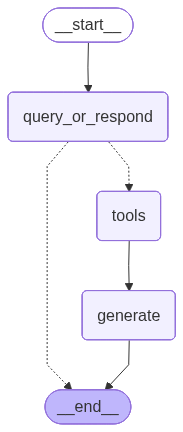

In [11]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Step 12: Test Simple Greeting

**Simple Query Test** - Testing the system with a basic greeting.

### Expected Behavior:
- **No Tool Calls**: The LLM should recognize this as a simple greeting
- **Direct Response**: Should respond without needing retrieval
- **Workflow Path**: query_or_respond → END (skipping tools and generate)

### Why This is Important:
- **Efficiency**: Simple queries don't need expensive retrieval operations
- **Performance**: Faster response times for basic interactions
- **Intelligence**: Demonstrates the LLM's ability to route appropriately

In [12]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I assist you today?


## Step 13: Test with Knowledge Query

**RAG Test** - Testing the complete retrieval-augmented generation workflow.

### Complex Query:
"What is Task Decomposition?" - A question that requires knowledge retrieval.

### Expected Workflow:
1. **query_or_respond**: LLM recognizes this needs domain knowledge
2. **Tool Call**: Generates a call to the retrieve tool with the query
3. **tools**: Executes similarity search and returns relevant documents
4. **generate**: Uses retrieved context to create an informed response

### Full RAG Pipeline:
- **Question Analysis**: LLM determines retrieval is needed
- **Context Retrieval**: Vector search finds relevant document chunks
- **Response Generation**: LLM synthesizes answer from retrieved context
- **Grounded Answer**: Response is based on actual document content, not just LLM training

### Observation Points:
- **Tool Call Message**: Shows the LLM's decision to use retrieval
- **Tool Response**: Displays the retrieved document chunks
- **Final Answer**: Grounded response based on retrieved context

In [13]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_ttpsMVia2OXeF2sKKm3iM0cN)
 Call ID: call_ttpsMVia2OXeF2sKKm3iM0cN
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights int

## Step 14: Add Memory and Persistence

**Conversation Memory** - Enabling multi-turn conversations with context persistence.

### What is MemorySaver?
- **In-Memory Checkpointing**: Stores conversation state in RAM
- **Thread-based Conversations**: Each conversation has a unique thread ID
- **State Persistence**: Maintains full message history across interactions
- **Automatic Management**: LangGraph handles state saving and loading

### How Checkpointing Works:
1. **State Snapshots**: After each step, the complete state is saved
2. **Thread Isolation**: Each conversation thread is independent
3. **Resume Capability**: Can continue conversations from any point
4. **History Access**: Full conversation context is available to the LLM

### Configuration:
- **Thread ID**: `"abc123"` - unique identifier for this conversation
- **Configurable**: Can be set per conversation for isolation
- **Persistent Memory**: The graph now remembers previous exchanges

### Benefits:
- **Context Continuity**: LLM remembers previous questions and answers
- **Follow-up Questions**: Can reference earlier parts of the conversation
- **Session Management**: Multiple independent conversation threads

In [14]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

## Step 15: Test with Persistent Memory

**Memory in Action** - Testing conversation persistence with the same query.

### Thread-based Memory:
- **Same Thread ID**: `"abc123"` - continues the previous conversation
- **Full Context**: The system remembers all previous interactions
- **State Continuity**: Complete message history is maintained

### What This Demonstrates:
- **Persistence**: Even though we're asking the same question, the system maintains context
- **Memory Management**: Previous messages remain accessible
- **State Isolation**: This thread is separate from other conversations
- **Conversation Flow**: Natural continuation of the dialogue

### Memory Benefits:
1. **Context Awareness**: LLM can reference previous exchanges
2. **Conversation Continuity**: Maintains natural dialogue flow
3. **Session Management**: Each thread maintains independent state
4. **Debugging**: Can trace full conversation history

In [15]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_gKWMZqx4P1s3PS1dvtKbVNKN)
 Call ID: call_gKWMZqx4P1s3PS1dvtKbVNKN
  Args:
    query: What is Task Decomposition?
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed l

## Step 16: Test Follow-up Questions

**Multi-turn Conversation** - Demonstrating contextual follow-up questions.

### The Follow-up Query:
"Can you look up some common ways of doing it?" - Notice the ambiguous reference "it"

### Context Resolution:
- **Pronoun Reference**: "it" refers to "Task Decomposition" from the previous exchange
- **Conversation Memory**: The system remembers the previous topic
- **Contextual Understanding**: LLM can resolve references from conversation history
- **Intelligent Retrieval**: May retrieve additional relevant information

### What Makes This Powerful:
1. **Natural Dialogue**: Users can speak naturally with pronouns and references
2. **Context Continuity**: No need to repeat the full question
3. **Progressive Discovery**: Build knowledge through a series of related questions
4. **Memory Integration**: Previous answers inform current responses

### Expected Behavior:
- The system should understand "it" refers to Task Decomposition
- May perform additional retrieval for "common ways" or "methods"
- Response should build on the previous conversation context

In [16]:
input_message = "Can you look up some common ways of doing it?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up some common ways of doing it?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_F2q9IIgyiBk4SudiPc7QrGwT)
 Call ID: call_F2q9IIgyiBk4SudiPc7QrGwT
  Args:
    query: common ways of performing task decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into m

## Step 17: Using Pre-built ReAct Agent

**LangGraph Pre-built Agents** - Leveraging ready-made agent architectures.

### What is ReAct?
**ReAct (Reasoning and Acting)** is a pattern where the LLM:
- **Reasons**: Thinks about what it needs to do
- **Acts**: Takes actions (calls tools)
- **Observes**: Reviews the results
- **Repeats**: Continues the cycle until the task is complete

### `create_react_agent` vs Custom Graph:
- **Pre-built**: Ready-to-use agent with built-in ReAct logic
- **Simplified Setup**: Just provide LLM, tools, and optional checkpointer
- **Proven Pattern**: Implements the well-established ReAct methodology
- **Less Control**: Trade customization for convenience

### When to Use Pre-built vs Custom:
- **Pre-built ReAct**: For standard reasoning + tool use patterns
- **Custom Graph**: For complex workflows with custom logic, multiple LLMs, or specialized routing

### Benefits of Pre-built Agents:
1. **Rapid Prototyping**: Get started quickly with proven patterns
2. **Best Practices**: Incorporates community learnings and optimizations
3. **Maintenance**: Updates and improvements come automatically
4. **Reliability**: Thoroughly tested and validated patterns

In [17]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

## Step 18: Visualize the ReAct Agent Graph

**ReAct Agent Architecture** - Understanding the pre-built agent structure.

### Comparing Graph Structures:
You'll notice differences between our custom graph and the ReAct agent:
- **Additional Nodes**: ReAct has more sophisticated reasoning steps
- **Loop Structures**: Can iterate through reasoning-action cycles
- **Built-in Logic**: Includes decision points for continuing vs stopping

### ReAct Flow Pattern:
1. **Agent**: Analyzes the input and decides on actions
2. **Tools**: Executes the chosen tools
3. **Reasoning**: Evaluates results and decides next steps
4. **Loop/Continue**: May repeat the cycle or provide final answer

### Advantages of Visualization:
- **Architecture Comparison**: See how different approaches structure workflows
- **Complexity Understanding**: ReAct agents have more sophisticated internal logic
- **Debugging**: Visual representation helps identify bottlenecks or issues
- **Learning**: Understand proven patterns for building agent systems

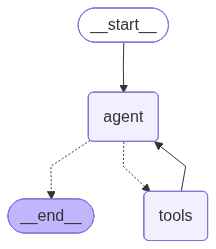

In [18]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

## Step 19: Test Complex Multi-step Query with ReAct Agent

**Advanced ReAct Capabilities** - Testing multi-step reasoning and multiple tool calls.

### Complex Query Structure:
The query has two distinct parts:
1. **"What is the standard method for Task Decomposition?"** - Initial knowledge request
2. **"Once you get the answer, look up common extensions of that method."** - Follow-up research

### ReAct Agent Advantages:
- **Multi-step Planning**: Can break down complex requests into sequential actions
- **Iterative Retrieval**: May call the retrieve tool multiple times
- **Reasoning Chain**: Explicitly reasons about each step
- **Adaptive Workflow**: Adjusts approach based on intermediate results

### Expected Behavior:
1. **First Retrieval**: Search for "standard method for Task Decomposition"
2. **Reasoning**: Analyze the results and identify the standard method
3. **Second Retrieval**: Search for "common extensions" of that specific method
4. **Synthesis**: Combine information from both retrievals into a comprehensive answer

### ReAct vs Custom Graph:
- **Custom Graph**: Fixed workflow (one retrieval per query)
- **ReAct Agent**: Dynamic workflow (multiple retrievals as needed)
- **Reasoning Transparency**: ReAct shows its thinking process
- **Complexity Handling**: Better suited for multi-step tasks

### New Thread ID:
Using `"def234"` creates a separate conversation thread, isolated from previous exchanges.

In [19]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_Sf8JPQhhHctQZaT3D43X034Y)
 Call ID: call_Sf8JPQhhHctQZaT3D43X034Y
  Args:
    query: What is the standard method for Task Decomposition?
  retrieve (call_AyZlgSBcbPQMWkbWA2xPpeLO)
 Call ID: call_AyZlgSBcbPQMWkbWA2xPpeLO
  Args:
    query: What are common extensions of the standard method for Task Decomposition?
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has beco